
# The impact of CEO turnover on company culture

### William Zhu (wzhu4@uchicago.edu)



## 0. Importing packages

In [5]:
#Special module written for content analysis
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
plt.style.use('fivethirtyeight')
import matplotlib.cm #Still for graphics
import matplotlib.patches as mpatches
import seaborn as sns #Makes the graphics look nicer
import spacy
import nltk

#%matplotlib inline

import itertools
import json

Importing data

In [6]:
df = pandas.read_csv('clean_df.csv', index_col=0)

In [7]:
df.head()

,ID,text,category,year,cat_id,tokenized_text,normalized_tokens
0,1,Best Company to work for People are smart and ...,google,2018,2,"['Best', 'Company', 'to', 'work', 'for', 'Peop...","['well', 'company', 'work', 'people', 'smart',..."
1,2,"Moving at the speed of light, burn out is inev...",google,2013,2,"['Moving', 'at', 'the', 'speed', 'of', 'light'...","['move', 'speed', 'light', 'burn', 'inevitable..."
2,3,Great balance between big-company security and...,google,2014,2,"['Great', 'balance', 'between', 'big', 'compan...","['great', 'balance', 'big', 'company', 'securi..."
3,4,The best place I've worked and also the most d...,google,2015,2,"['The', 'best', 'place', 'I', ""'ve"", 'worked',...","['well', 'place', 'have', 'work', 'demand', 'f..."
4,10,Execellent for engineers Impact driven. Best t...,google,2018,2,"['Execellent', 'for', 'engineers', 'Impact', '...","['execellent', 'engineer', 'impact', 'drive', ..."


## 3. Changes in 9 values by year

### (3a) counting changes in keywords of 9 values
    
    

In [8]:
# Create 6 datasets
 
df0 = df[df['cat_id']==0].reset_index()
df1 = df[df['cat_id']==1].reset_index()
df2 = df[df['cat_id']==2].reset_index()
df3 = df[df['cat_id']==3].reset_index()
df4 = df[df['cat_id']==4].reset_index()
df5 = df[df['cat_id']==5].reset_index()

Useful functions and constants

In [9]:
#nlp = spacy.load("en")
#nlp.max_length = 100000

In [10]:
V1 = ['agility', 'agile', 'flexible', 'flexibility', 'nimble', 'fast']
V2 = ['collaborate', 'collaboration', 'teamwork', 'cooperate', 'cooperation' 'teammates', 'colleagues','colleague', 'coworkers', 'coworker', 'helpful', 'help']
V3 = ['customer', 'customers', 'clients', 'client']
V4 = ['diversity', 'diverse', 'inclusive', 'inclusion', 'welcome', 'welcoming', 'welcomed', 'accepted', 'embraced', 'equitable', 'equity']
V5 = ['execute', 'execution', 'empower', 'empowered', 'own','ownership']
V6 = ['cutting', 'edge', 'change', 'innovative', 'innovate', 'creative', 'create']
V7 = ['integrity', 'ethical', 'ethic', 'ethics', 'honest', 'honesty', 'right', 'moral', 'morality', 'character', 'honor']
V8 = ['meritocratic', 'meritocracy', 'results', 'result', 'outcome', 'performance', 'perform']
V9 = ['respect', 'respected', 'dignity', 'courtesy', 'friendly',  'appreciated', 'appreciation', 'appreciate', 'care']
vall = [V1, V2, V3, V4, V5, V6, V7, V8, V9]

In [11]:
def vcount(df):
    out = []
    for i in range(len(df)):
        row = []
        row.append(df.loc[i, 'year'])
        length = len(df.loc[i, 'tokenized_text'])
        row.append(length)
        text = nltk.Text(df['tokenized_text'][i])
        for v in vall:
            count = 0
            for word in v:
                count += text.count(word)
            row.append(round(10000*count/length,2))
        out.append(row)
    outdf = pandas.DataFrame(out, columns=["year", "length", 'agility', 'collaboration', 'customer', 'diversity', 'execution', 'innovation', 'integrity', 'performance', 'respect'])
    return outdf

In [12]:
def draw_graph(tb, name):
    fig = plt.figure(figsize = (17,5))
    plt.rc('font', size=18)
    title = f"changes in {name}'s Cultural Values over the years"
    plt.title(title) 
    plt.plot('year', 'agility', data=tb, color ='#00F9FF', linewidth=7)
    plt.plot('year', 'collaboration', data=tb, color ='#00E0C0', linewidth=7)
    plt.plot('year', 'customer', data=tb, color ='#00EF4E', linewidth=7)
    plt.plot('year', 'diversity', data=tb, color ='#D2FC00', linewidth=7)
    plt.plot('year', 'execution', data=tb, color ='#F8D800', linewidth=7)
    plt.plot('year', 'innovation', data=tb, color ='#F47B5B', linewidth=7)
    plt.plot('year', 'integrity', data=tb, color ='#B700F4', linewidth=7)
    plt.plot('year', 'performance', data=tb, color ='#7600FF', linewidth=7)
    plt.plot('year', 'respect', data=tb, color ='#4523FF', linewidth=7)
    plt.legend(loc="upper right")
    plt.show()

### Start with df0 (amazon)

In [13]:
df0['year'].value_counts()

2018    7421
2017    6678
2016    4039
2015    2951
2014    1321
2013     784
2012     453
2011     117
2008      98
2009      68
2010      60
Name: year, dtype: int64

In [14]:
#collapse the reviews to one row for each year
df0 = df0.groupby('year')['text'].apply(','.join).reset_index()

In [15]:
# count the number of characters in each row
for i in range(11):
  print(len(df0['text'][i]))

89998
62425
47822
76795
225258
436208
775730
1344734
1622337
2633515
2599637


In [16]:
#Because Amazon has too many reviews from 2015 to 2018, the nlp cannot take so many characters.
#Hence, we keep the first 1,000,000 characters in each row of 'text' (only affect the last four years)
df0['text'] = df0['text'].map(lambda x: x[:1000000])

In [17]:
df0['tokenized_text'] = df0['text'].apply(lambda x: lucem_illud.word_tokenize(x))

In [18]:
tb0 = vcount(df0)

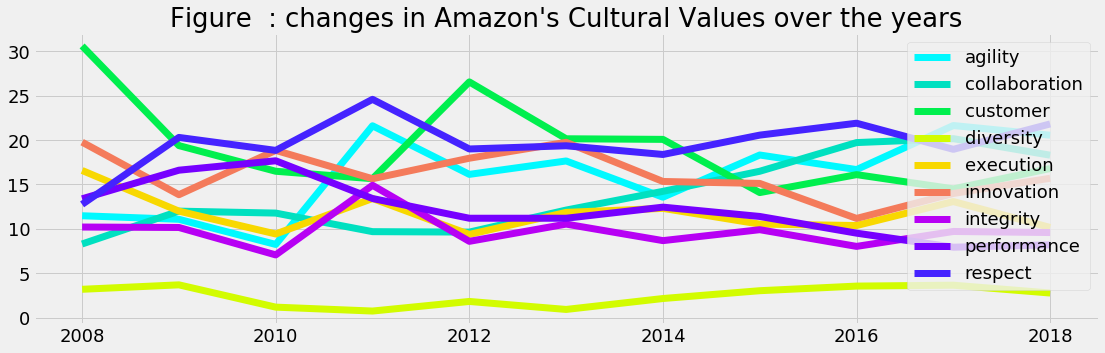

In [19]:
draw_graph(tb0, 'Amazon')

df1: netflix

In [12]:
#collapse the reviews to one row for each year
df1 = df1.groupby('year')['text'].apply(','.join).reset_index()
df2 = df2.groupby('year')['text'].apply(','.join).reset_index()
df3 = df3.groupby('year')['text'].apply(','.join).reset_index()
df4 = df4.groupby('year')['text'].apply(','.join).reset_index()
df5 = df5.groupby('year')['text'].apply(','.join).reset_index()

In [13]:
df1['tokenized_text'] = df1['text'].apply(lambda x: lucem_illud.word_tokenize(x))
df2['tokenized_text'] = df2['text'].apply(lambda x: lucem_illud.word_tokenize(x))
df3['tokenized_text'] = df3['text'].apply(lambda x: lucem_illud.word_tokenize(x))
df4['tokenized_text'] = df4['text'].apply(lambda x: lucem_illud.word_tokenize(x))
df5['tokenized_text'] = df5['text'].apply(lambda x: lucem_illud.word_tokenize(x))

In [14]:
tb1 = vcount(df1)
tb2 = vcount(df2)
tb3 = vcount(df3)
tb4 = vcount(df4)
tb5 = vcount(df5)

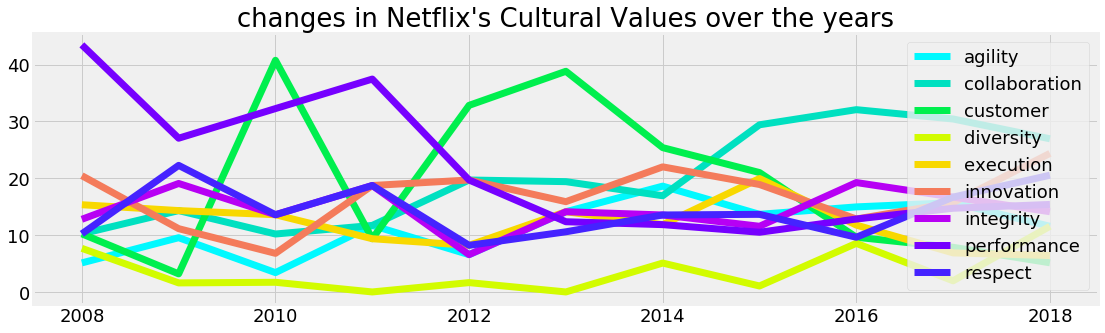

In [52]:
draw_graph(tb1, 'Netflix')

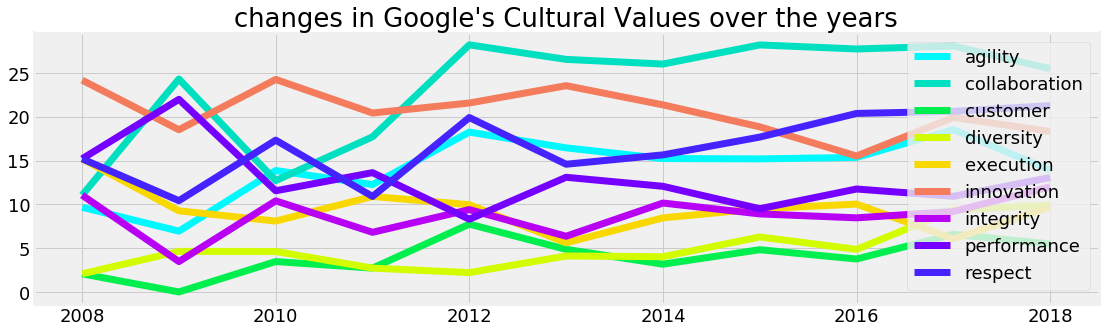

In [50]:
draw_graph(tb2, 'Google')

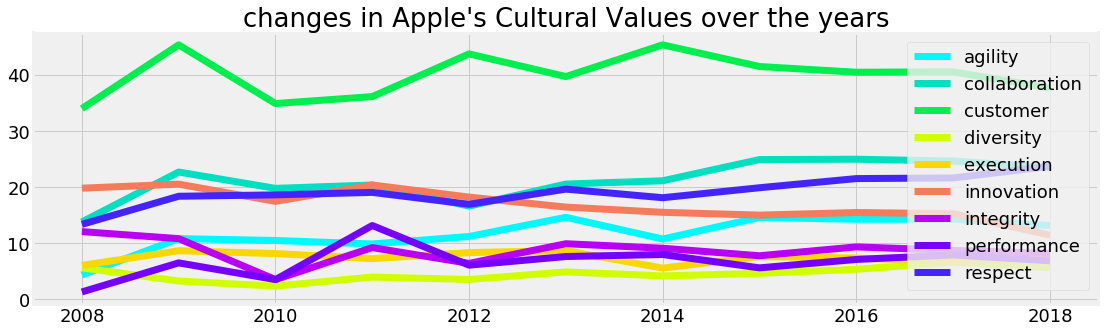

In [49]:
draw_graph(tb3, 'Apple')

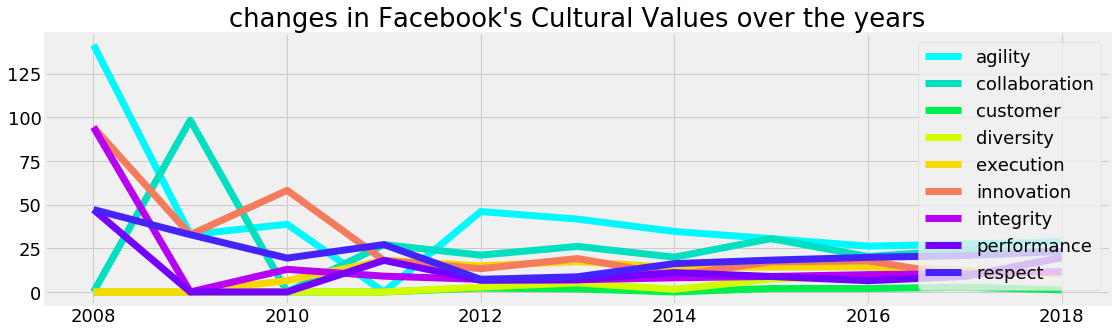

In [53]:
draw_graph(tb4, 'Facebook')

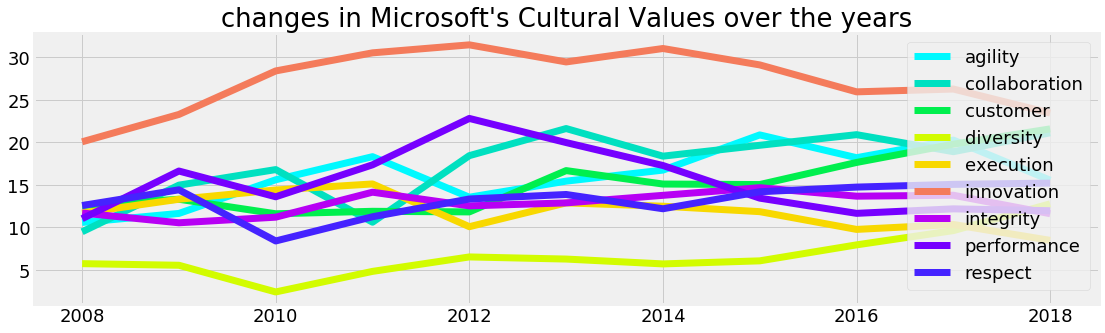

In [48]:
draw_graph(tb5, 'Microsoft')

### (3b) projection

In [194]:
df.head()

,ID,text,category,year,cat_id,tokenized_text,normalized_tokens
0,1,Best Company to work for People are smart and ...,google,2018,2,"['Best', 'Company', 'to', 'work', 'for', 'Peop...","['well', 'company', 'work', 'people', 'smart',..."
1,2,"Moving at the speed of light, burn out is inev...",google,2013,2,"['Moving', 'at', 'the', 'speed', 'of', 'light'...","['move', 'speed', 'light', 'burn', 'inevitable..."
2,3,Great balance between big-company security and...,google,2014,2,"['Great', 'balance', 'between', 'big', 'compan...","['great', 'balance', 'big', 'company', 'securi..."
3,4,The best place I've worked and also the most d...,google,2015,2,"['The', 'best', 'place', 'I', ""'ve"", 'worked',...","['well', 'place', 'have', 'work', 'demand', 'f..."
4,10,Execellent for engineers Impact driven. Best t...,google,2018,2,"['Execellent', 'for', 'engineers', 'Impact', '...","['execellent', 'engineer', 'impact', 'drive', ..."


Useful functions

In [54]:
def sents(df):
    df['tokenized_sents'] = df['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])

    df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])
    return df

In [55]:
def year_split(df):
    df1 = df[(df['year']==2008) |(df['year']==2009)|(df['year']==2010)]
    df2 = df[(df['year']==2011) |(df['year']==2012)]
    df3 = df[(df['year']==2013) |(df['year']==2014)]
    df4 = df[(df['year']==2015) |(df['year']==2016)]
    df5 = df[(df['year']==2017) |(df['year']==2018)]
    dfall = [df1, df2, df3, df4, df5]
    return dfall


In [56]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [57]:
keywords = ['culture', 'management', 'leadership']

In [58]:
def makeDF(model, word_list):
    s = []
    for word in word_list:
        s.append(sklearn.metrics.pairwise.cosine_similarity(dfW2V[word].reshape(1,-1), sentiment.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'sentiment': s}, index = word_list)
    return df

In [72]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.copper(z))
    return c

def PlotDimension(ax,df, dim, tt):
    ax.set_frame_on(False)
    ax.set_title(tt, fontsize = 20, loc='right')
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 1, fontsize = 28, weight='bold')
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY, MaxY)
    plt.yticks(())
    plt.xticks(())

In [59]:
def operation(df, lim=1000):
    #for years with more than 1000 reviews, only sample 1000 reviews.
    df = df.groupby('year').apply(lambda x: x.sample(lim, random_state=123) if len(x) > lim else x).reset_index(drop=True)
    dftemp = sents(df)
    dfall = year_split(dftemp)
    return dfall


In [60]:
# Create 6 datasets
 
df0 = df[df['cat_id']==0].reset_index()
df1 = df[df['cat_id']==1].reset_index()
df2 = df[df['cat_id']==2].reset_index()
df3 = df[df['cat_id']==3].reset_index()
df4 = df[df['cat_id']==4].reset_index()
df5 = df[df['cat_id']==5].reset_index()

Amazon

In [5]:
df0['year'].value_counts()

2018    7421
2017    6678
2016    4039
2015    2951
2014    1321
2013     784
2012     453
2011     117
2008      98
2009      68
2010      60
Name: year, dtype: int64

In [84]:
dfall = operation(df0, 1000)

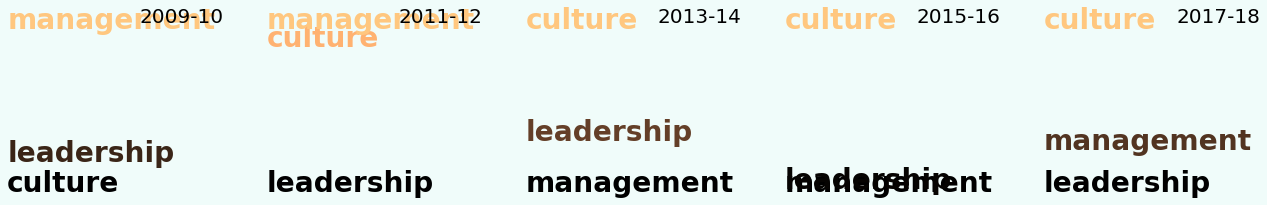

In [88]:
fig = plt.figure(figsize = (20,3))
fig.set_facecolor('#f0fcfa')
for i in range(len(dfall)):
    dfW2V = gensim.models.word2vec.Word2Vec(dfall[i]['normalized_sents'].sum())
    sentiment = dimension(dfW2V, ['good', 'great', 'high'], ['bad', 'poor', 'low'])
    worddf = makeDF(dfW2V, keywords)
    ax1 = fig.add_subplot(1, 5, int(i+1))
    PlotDimension(ax1, worddf, 'sentiment', f'{str(2009+i*2)}-{str(10 + i*2)}')
#plt.show()
plt.savefig('output_3/az.png', bbox_inches='tight')

df1: Netflix dropped because not enough reviews

df2: Google

In [187]:
df2['year'].value_counts()

2017    1298
2015    1249
2016    1186
2018    1171
2014     703
2013     394
2012     272
2011      94
2008      77
2010      75
2009      51
Name: year, dtype: int64

In [80]:
dfall = operation(df2, 1000)

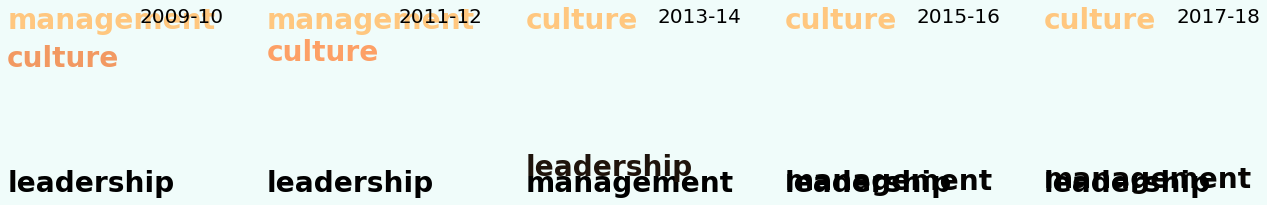

In [83]:
fig = plt.figure(figsize = (20,3))
fig.set_facecolor('#f0fcfa')
for i in range(len(dfall)):
    dfW2V = gensim.models.word2vec.Word2Vec(dfall[i]['normalized_sents'].sum())
    sentiment = dimension(dfW2V, ['good', 'great', 'high'], ['bad', 'poor', 'low'])
    worddf = makeDF(dfW2V, keywords)
    ax1 = fig.add_subplot(1, 5, int(i+1))
    PlotDimension(ax1, worddf, 'sentiment', f'{str(2009+i*2)}-{str(10 + i*2)}')

plt.savefig('output_3/gg.png', bbox_inches='tight')

df3: apple

In [239]:
df3['year'].value_counts()

2016    2410
2017    2207
2015    2066
2018    1786
2014    1306
2013     793
2012     395
2011     171
2008     139
2010      90
2009      88
Name: year, dtype: int64

In [89]:
dfall = operation(df3, 1000)

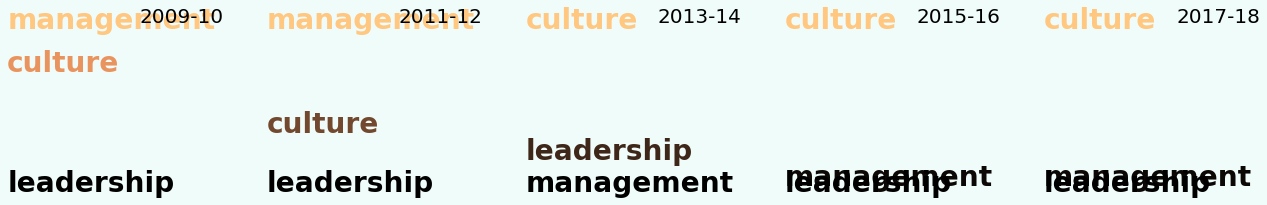

In [90]:
fig = plt.figure(figsize = (20,3))
fig.set_facecolor('#f0fcfa')
for i in range(len(dfall)):
    dfW2V = gensim.models.word2vec.Word2Vec(dfall[i]['normalized_sents'].sum())
    sentiment = dimension(dfW2V, ['good', 'great', 'high'], ['bad', 'poor', 'low'])
    worddf = makeDF(dfW2V, keywords)
    ax1 = fig.add_subplot(1, 5, int(i+1))
    PlotDimension(ax1, worddf, 'sentiment', f'{str(2009+i*2)}-{str(10 + i*2)}')

plt.savefig('output_3/ap.png', bbox_inches='tight')

df4: facebook: not enough reviews

df5: microsoft

In [250]:
df5['year'].value_counts()

2015    2805
2016    2626
2017    2364
2014    2073
2018    1765
2013    1559
2012    1238
2011     371
2008     274
2010     214
2009     139
Name: year, dtype: int64

In [91]:
dfall = operation(df5, 1000)

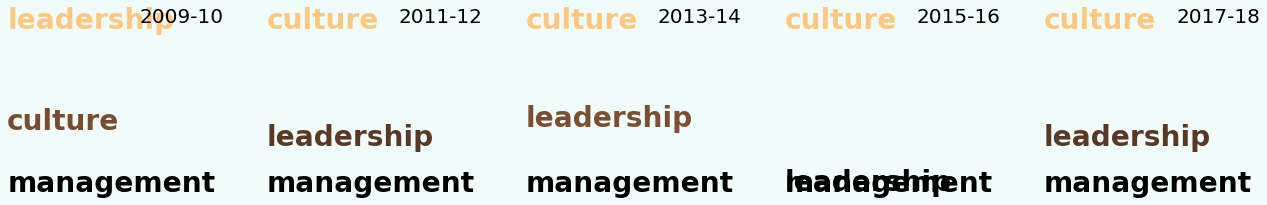

In [92]:
fig = plt.figure(figsize = (20,3))
fig.set_facecolor('#f0fcfa')
for i in range(len(dfall)):
    dfW2V = gensim.models.word2vec.Word2Vec(dfall[i]['normalized_sents'].sum())
    sentiment = dimension(dfW2V, ['good', 'great', 'high'], ['bad', 'poor', 'low'])
    worddf = makeDF(dfW2V, keywords)
    ax1 = fig.add_subplot(1, 5, int(i+1))
    PlotDimension(ax1, worddf, 'sentiment', f'{str(2009+i*2)}-{str(10 + i*2)}')

plt.savefig('output_3/ms.png', bbox_inches='tight')